# Exploring consumer behavior in the United States during the pandemic

In this notebook, I am exploring spending trend in the United States with respect to covid rate. I will be using the following datasets:

1. state data (geoid) 
2. covid case rate
3. consumer spending

In [505]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Reading Data with Pandas

In [506]:
state_data = pd.read_csv('data/geoid.csv')
covid_data = pd.read_csv('data/covid.csv')
spending_data = pd.read_csv('data/spending.csv', usecols=['year', 'month', 'day', 'statefips', 'spend_all'])

Now let's take a look at samples from these datasets and preprocess according to our need.

## Preprocessing

### State Data (Geoid)

In [507]:
state_data.sample(50)

,statefips,statename,stateabbrev,state_pop2019
20,24,Maryland,MD,6045680
40,45,South Carolina,SC,5148714
11,15,Hawaii,HI,1415872
2,4,Arizona,AZ,7278717
38,42,Pennsylvania,PA,12801989
26,30,Montana,MT,1068778
35,39,Ohio,OH,11689100
19,23,Maine,ME,1344212
13,17,Illinois,IL,12671821
1,2,Alaska,AK,731545


The state data will be used for joining the remaining datasets on the **'statefips' key** and therefore we keep the state data as is. Here 'statefips' is the standard id for states based on the **"Federal Information Processing Standards"**.

### Covid Data

In [508]:
covid_data.head()

,year,month,day,statefips,case_rate,new_case_rate
0,2020,1,21,1,0.0,.
1,2020,1,21,2,0.0,.
2,2020,1,21,4,0.0,.
3,2020,1,21,5,0.0,.
4,2020,1,21,6,0.0,.


In the covid dataset, the primary attributes are as follows:

1. **case_rate**: Seven day moving average of COVID cases per 100,000 people
2. **new_case_rate**: Seven day moving average of *new* COVID cases per 100,000 people

In [509]:
covid_data.dtypes

year               int64
month              int64
day                int64
statefips          int64
case_rate        float64
new_case_rate     object
dtype: object

We can see that 'year', 'month' and 'day' columns are int64. But, we will convert these to str type so that we can concatenate these into a Pandas date_range. At the same time, we can see that 'new_case_rate' column is an object type. But, it should have been a float64 type like case_rate. If we take a look at the data, we will see that missing values represented by '.' cause this column to be of object type. So, let's change the '.' values to **None** values and convert the 'new_case_rate' column type to float64. Finally, since statefips represents the state ids, we should convert it to a categorical variable.

In [510]:
covid_data.loc[covid_data['new_case_rate']=='.', 'new_case_rate'] = None
covid_data = covid_data.astype({'year': str, 'month': str, 'day': str, 'statefips': 'category', 'new_case_rate': float});
covid_data.dtypes

year               object
month              object
day                object
statefips        category
case_rate         float64
new_case_rate     float64
dtype: object

Now that we have converted the data types according to our convenience, we can concatenate the 'year', 'month' and 'day' columns and convert that into a Pandas date_range.

In [511]:
if {'year', 'month', 'day'}.issubset(covid_data.columns):
    covid_data['date'] = covid_data['year'].str.cat(covid_data['month'], sep="-").str.cat(covid_data['day'], sep="-")
    covid_data.drop(['year', 'month', 'day'], axis=1, inplace=True)

covid_data['date'] = covid_data['date'].astype('datetime64[ns]')
covid_data.set_index('date', inplace=True)
covid_data.head(1000)

,statefips,case_rate,new_case_rate
date,,,
2020-01-21,1,0.0,NaN
2020-01-21,2,0.0,NaN
2020-01-21,4,0.0,NaN
2020-01-21,5,0.0,NaN
2020-01-21,6,0.0,NaN
...,...,...,...
2020-02-09,30,0.0,0.0
2020-02-09,31,0.0,0.0
2020-02-09,32,0.0,0.0


Now let's fill in the missing values using Pandas interpolation function with the 'time' method since 'time' method is appropriate for daily high resolution values.

In [512]:
covid_data['new_case_rate'].interpolate(method='time', axis=0, limit_direction='both', inplace=True)

In [513]:
covid_data.describe()

,case_rate,new_case_rate
count,11373.000000,11373.000000
mean,480.150184,6.927914
std,618.420496,8.737471
min,0.000000,0.000000
25%,1.020000,0.100000
50%,194.000000,3.950000
75%,769.000000,9.930000
max,3184.000000,55.300000


In [514]:
covid_data.head()

,statefips,case_rate,new_case_rate
date,,,
2020-01-21,1,0.0,0.0
2020-01-21,2,0.0,0.0
2020-01-21,4,0.0,0.0
2020-01-21,5,0.0,0.0
2020-01-21,6,0.0,0.0


As we can see, case_rate and new_case_rate have a very high range. For better analysis and easier comparison, let's scale the 'case_rate' and 'new_case_rate' columns so that the values are within the range 0-1.

In [515]:
scaler = MinMaxScaler()

covid_data['case_rate'] = scaler.fit_transform(np.expand_dims(covid_data['case_rate'].to_numpy(), axis=1))
covid_data['new_case_rate'] = scaler.fit_transform(np.expand_dims(covid_data['new_case_rate'].to_numpy(), axis=1))

In [516]:
covid_data.sample(1000)

,statefips,case_rate,new_case_rate
date,,,
2020-03-23,4,0.001008,0.007667
2020-07-26,44,0.540201,0.105063
2020-03-12,9,0.000053,0.000434
2020-04-27,9,0.228957,0.448463
2020-04-15,30,0.011872,0.017396
...,...,...,...
2020-07-17,31,0.363065,0.204340
2020-01-27,50,0.000000,0.000000
2020-05-21,23,0.043970,0.060036


### Spending Data

In [517]:
spending_data.head()

,year,month,day,statefips,spend_all
0,2020,1,21,1,0.01090
1,2020,1,21,2,-0.00965
2,2020,1,21,4,0.00919
3,2020,1,21,5,0.01770
4,2020,1,21,6,0.01110


In [518]:
spending_data.loc[spending_data['spend_all']=='.', 'spend_all'] = None
spending_data = spending_data.astype({'year': str, 'month': str, 'day': str, 'statefips': 'category', 'spend_all': float});
spending_data.dtypes

year           object
month          object
day            object
statefips    category
spend_all     float64
dtype: object

In [519]:
if {'year', 'month', 'day'}.issubset(spending_data.columns):
    spending_data['date'] = spending_data['year'].str.cat(spending_data['month'], sep="-").str.cat(spending_data['day'], sep="-")
    spending_data.drop(['year', 'month', 'day'], axis=1, inplace=True)

spending_data['date'] = spending_data['date'].astype('datetime64[ns]')
spending_data.set_index('date', inplace=True)
spending_data.head(1000)

,statefips,spend_all
date,,
2020-01-21,1,0.01090
2020-01-21,2,-0.00965
2020-01-21,4,0.00919
2020-01-21,5,0.01770
2020-01-21,6,0.01110
...,...,...
2020-02-09,30,0.12000
2020-02-09,31,0.02500
2020-02-09,32,0.03510


## Merging the Datasets

In [520]:
date_index = spending_data.index

merged_data_temp = pd.merge(covid_data, spending_data, left_on=['date', 'statefips'], right_on=['date', 'statefips'], how='inner')
data = pd.merge(state_data, merged_data_temp, left_on=['statefips'], right_on=['statefips'], how="right")

data.set_index(date_index, inplace=True)

## Analysis

Since we can work with either statename or stateabbrev, we can drop one of these. Let's drop the column 'statename'.

In [521]:
if {'statename'}.issubset(data.columns):
    data.drop(['statename'], axis=1, inplace=True)
    
data.sample(100)

,statefips,stateabbrev,state_pop2019,case_rate,new_case_rate,spend_all
date,,,,,,
2020-05-10,30,MT,1068778,0.000000,0.000000,0.07070
2020-06-27,41,OR,4217737,0.012940,0.025497,-0.31100
2020-02-16,9,CT,3565287,0.000018,0.000145,-0.05100
2020-07-21,48,TX,28995881,0.000000,0.000000,-0.00383
2020-04-17,24,MD,6045680,0.327261,0.147920,-0.13400
...,...,...,...,...,...,...
2020-02-02,4,AZ,7278717,0.807161,0.305606,-0.02400
2020-02-01,4,AZ,7278717,0.287688,0.701627,-0.12000
2020-05-19,32,NV,3080156,0.000000,0.000000,-0.00913


Let's plot the 'new_case_rate' vs. 'spend_all' using a line chart and compare the trends.

In [548]:
def plotByStates(df):
    title = df.stateabbrev
    x = df.index
    y1 = df.new_case_rate
    y2 = df.spend_all
    
    fig, ax = plt.subplots()
    
    ax.plot(x, y1, 'g', label='new_case_rate')
    ax.plot(x, y2, 'b', label='spend_all')
    ax.legend(loc='upper left')
#     ax.set_title(title)

""


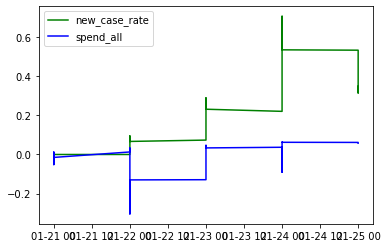

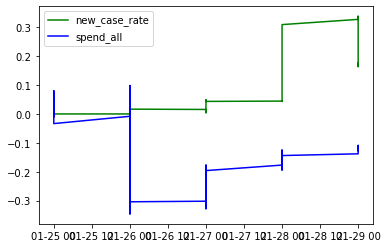

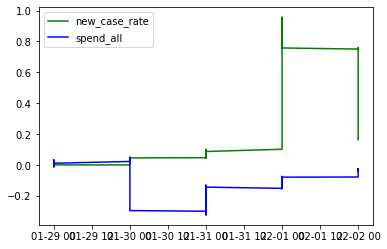

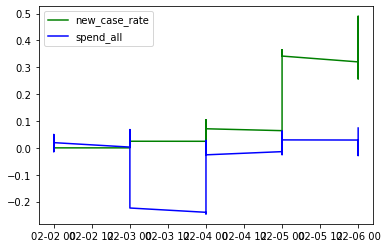

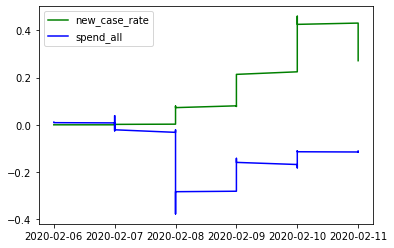

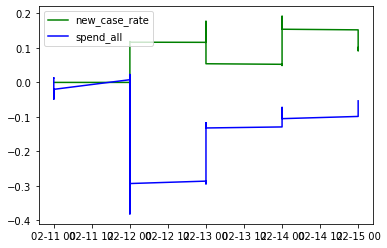

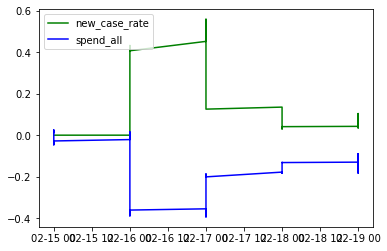

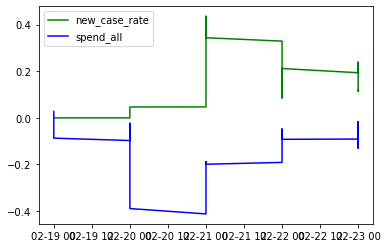

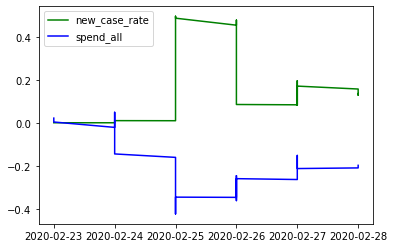

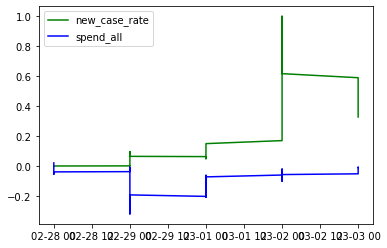

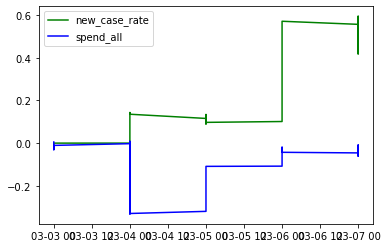

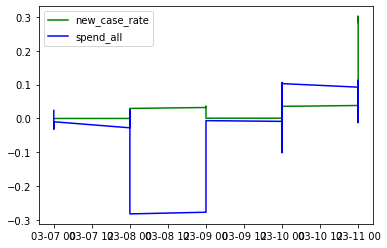

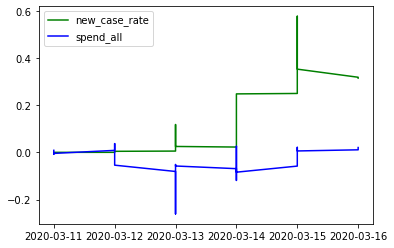

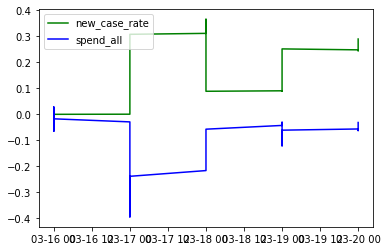

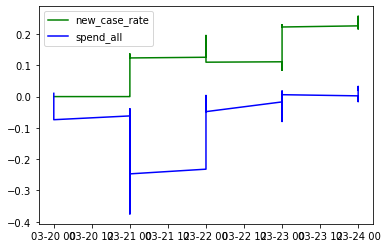

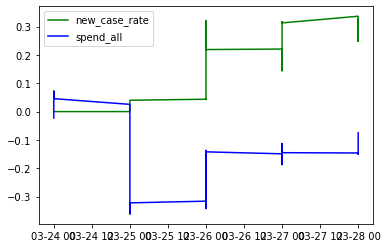

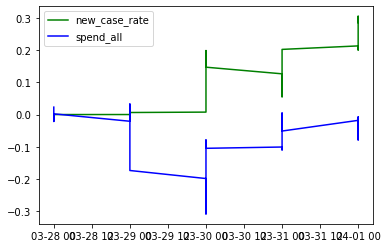

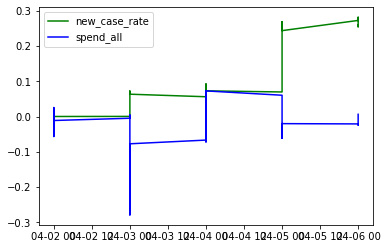

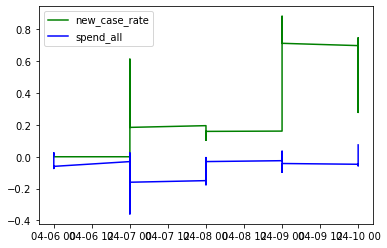

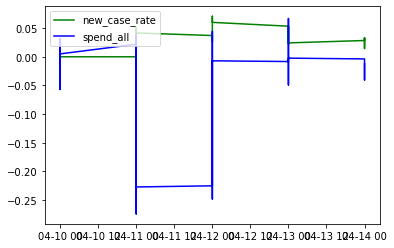

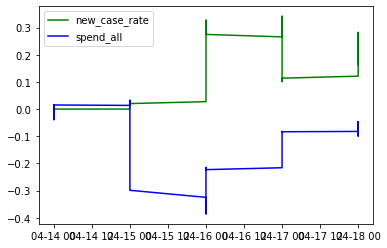

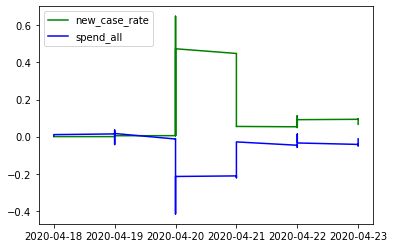

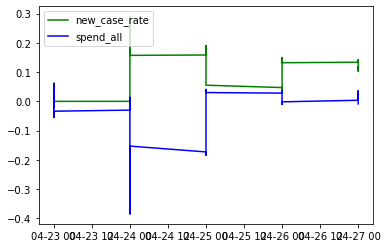

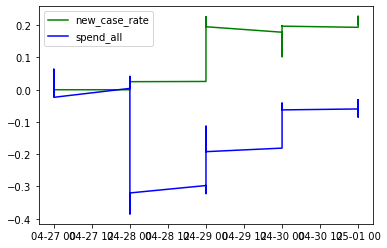

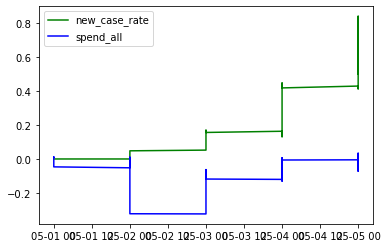

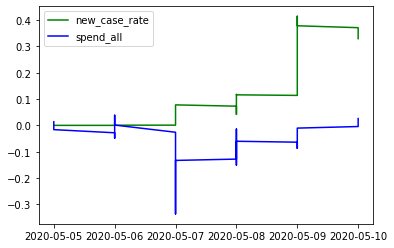

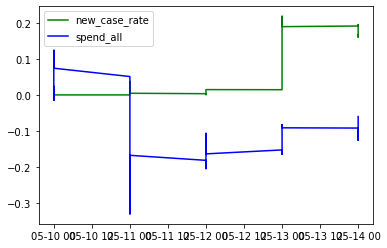

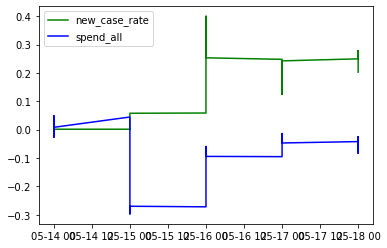

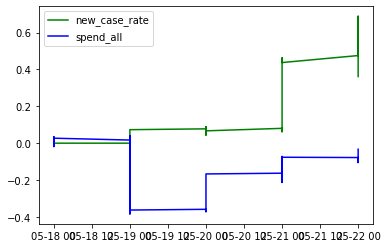

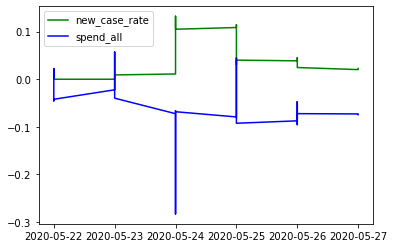

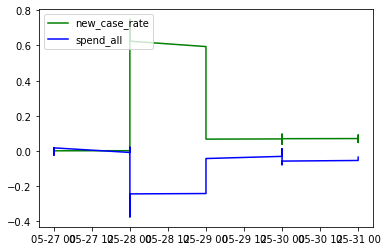

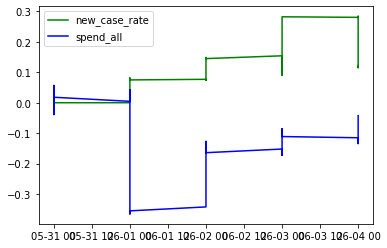

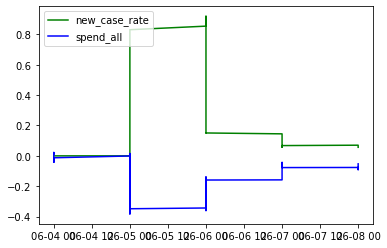

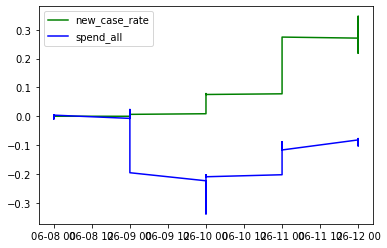

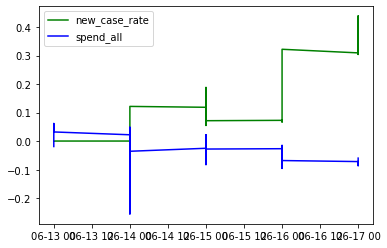

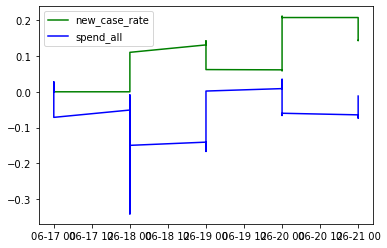

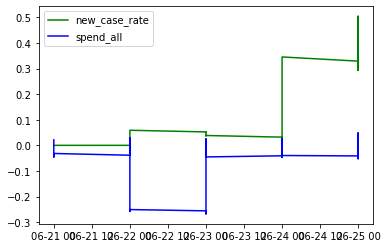

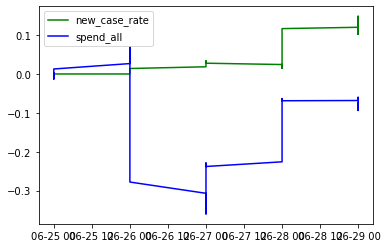

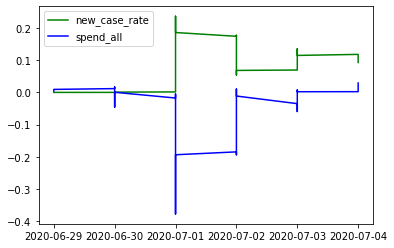

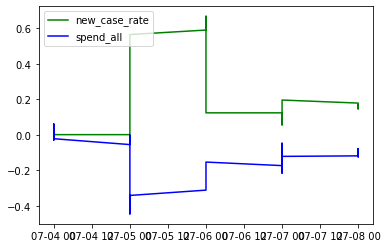

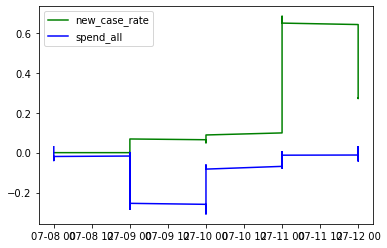

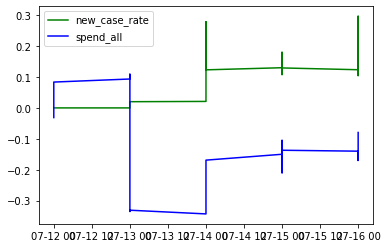

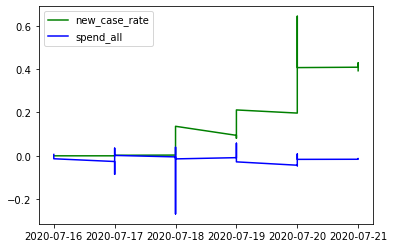

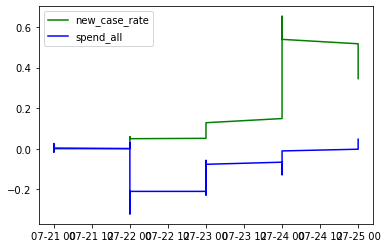

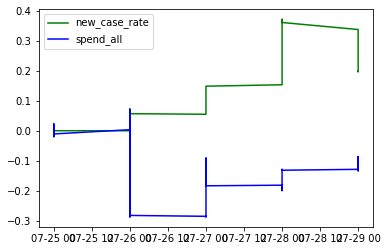

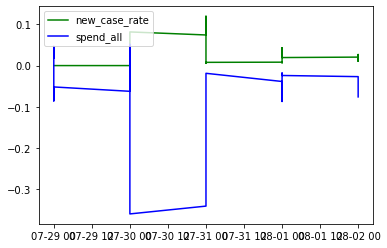

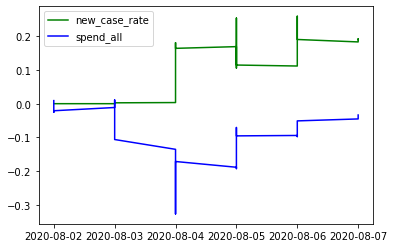

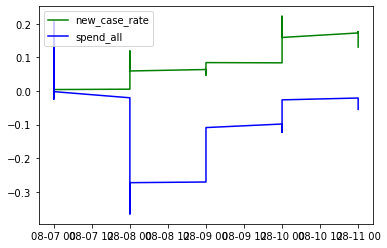

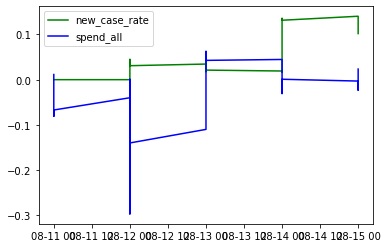

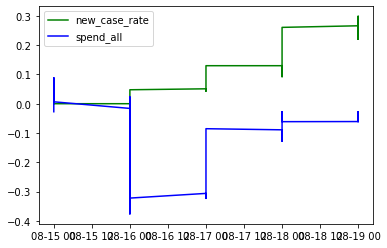

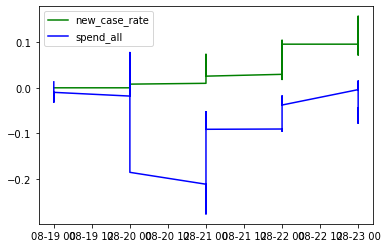

In [549]:
data.groupby('statefips').apply(lambda frame: plotByStates(frame))

Now let's plot the correlation heatmap to see which columns correlate to another.

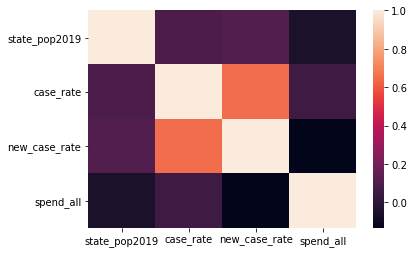

In [524]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

**Observations**: 

1. Surprisingly, state populations don't correlate to the state spending which means that even if some state might have fewer population, those fewer people might spend more.

2. Equally surprising was that, COVID case rises didn't affect spending from a bird's eye view. However, it is quite likely that if we explore spending data on a higher resolution (e.g. spending based on industries), that might lead to higher correlation between the number of cases and spending.

## References

1. "How Did COVID-19 and Stabilization Policies Aﬀect Spending and Employment? A New Real-Time Economic Tracker Based on Private Sector Data", by Raj Chetty, John Friedman, Nathaniel Hendren, Michael Stepner, and the Opportunity Insights Team. June 2020. Available at: https://opportunityinsights.org/wp-content/uploads/2020/05/tracker_paper.pdf

2. Economic tracker - https://tracktherecovery.org

3. Datasets - https://github.com/opportunityinsights/economictracker